In [1]:
import sys
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data.dataloader import default_collate
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch
import pickle


# Append the project dir to path
sys.path.append(os.path.join("..", "..", ".."))
from data_pipeline.utils import train_test_split, create_metadata_df, get_sample_weights_of_dataset, measurements_to_df
from data_pipeline.dataset_xy import CARLADatasetXY
from data_pipeline.dataset_xy_opt import CARLADatasetXYOpt
from data_pipeline.data_sampler import BranchPerCommandSampler
from data_pipeline.data_preprocessing import preprocessing
from models.resnet_baseline.architectures_v3 import Resnet_Baseline_V3, Resnet_Baseline_V3_Dropout
from models.resnet_baseline.architectures_v5 import Resnet_Baseline_V5
from models.resnet_lidar.lidar_v1 import Resnet_Lidar_V1, Resnet_Lidar_V1_Dropout, Resnet_Lidar_V1_Dropout_2
from models.model_trainer import ModelTrainer

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loss_test1 = [0.0782,
0.0543,
0.0477,
0.0424,
0.0390,
0.0381,
0.0385,
0.0378,
0.0356,
0.0364,
0.0370,
0.0350,
0.0353,
0.0340,
0.0336,
0.0328,
0.0346,
0.0337,
0.0321,
0.0331]

In [3]:
df_per_stats = pd.read_csv("/Users/julianvonklitzing/Documents/GitHub/end2endappras/models/resnet_baseline/notebooks/experiment_files/2023_02_26_10_43/stats/stats_performance.csv")

In [11]:
df_per_stats = df_per_stats[df_per_stats.columns[-3:]].sum(axis=1).to_frame("val_test2")
df_per_stats["val_test1"] = loss_test1

<AxesSubplot: >

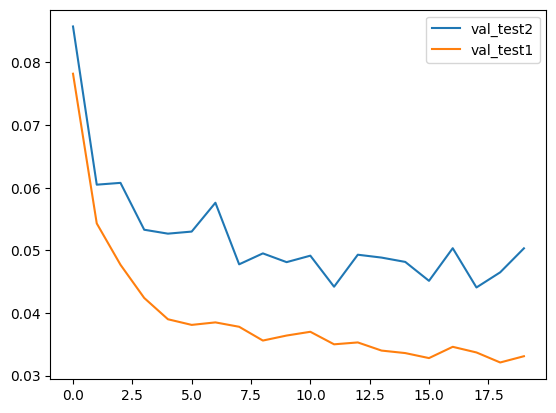

In [20]:
df_per_stats.plot()

In [41]:
df_per_stats_weighted = df_per_stats * [0.5, 0.5]# [35975 / (17306 + 35975), 17306 / (17306 + 35975)]

In [43]:
df_per_stats_weighted.sum(axis=1).argmin()

17

In [40]:
df_per_stats

,val_test2,val_test1
0,0.085743,0.0782
1,0.060486,0.0543
2,0.060775,0.0477
3,0.053293,0.0424
4,0.052667,0.0390
5,0.052998,0.0381
6,0.057602,0.0385
7,0.047771,0.0378
8,0.049517,0.0356
9,0.048119,0.0364


In [17]:
np.argmin(df_per_stats.values, axis=0)

array([17, 18])

## Choose training settings

In [21]:
# Set data balancing options (if both false, then no balancing is applied)
use_balance_by_loss_weighting = False
use_balance_by_over_under_sampling = False

assert not use_balance_by_loss_weighting or not use_balance_by_over_under_sampling

In [22]:
# Train additionally on the noisy data
use_data_noisy = True

path_data_noisy = None
if use_data_noisy:
    path_data_noisy = os.path.join("..", "..", "..", "data", "Noise-Dataset")

## Create Datasets

In [23]:
path_data = os.path.join("..", "..", "..", "data", "data")

config_xy = {"used_inputs": ["rgb", "lidar_bev", "measurements"], 
        "used_measurements": ["speed", "steer", "throttle", "brake", "command"],
        "y": ["brake", "steer", "throttle"],
        "seq_len": 1
        }

# config_xy = {"used_inputs": ["rgb", "measurements"], 
#         "used_measurements": ["speed", "waypoints", "command"],
#         "y": ["waypoints"],
#         "seq_len": 1
#         }

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.has_mps else 'cpu')
batch_size = 64

# Create df_meta 
df_meta_data = create_metadata_df(path_data, config_xy["used_inputs"])
df_meta_data_noisy = None
if use_data_noisy:
    df_meta_data_noisy = create_metadata_df(path_data_noisy, config_xy["used_inputs"])

# Train/test split
train_test_config = {
    "train": ['Town00', 'Town01', 'Town02', 'Town03', 'Town04', 'Town05', 'Town07', 'Town08', 'Town09', 'Town10'],
    "test": ['Town06']
}
df_meta_data_train, df_meta_data_test_1, df_meta_data_test_2 = train_test_split(df_meta_data, towns_intersect=train_test_config, df_meta_data_noisy=df_meta_data_noisy)

# Decrease train/test size for quick test run
# df_meta_data_train = df_meta_data_train.head(5 * batch_size)
# df_meta_data_test_1 = df_meta_data_test_1.head(5 * batch_size)
# df_meta_data_test_2 = df_meta_data_test_2.head(5 * batch_size)

# Create Dataset & DataLoader
dataset_train = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_train, config=config_xy)
dataset_test_1 = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_test_1, config=config_xy)
dataset_test_2 = CARLADatasetXY(root_dir=path_data, df_meta_data=df_meta_data_test_2, config=config_xy)

# dataset_train = CARLADatasetXYOpt(df_meta_data_train)
# dataset_test_1 = CARLADatasetXYOpt(df_meta_data_test_1)
# dataset_test_2 = CARLADatasetXYOpt(df_meta_data_test_2)

In [27]:
df_meta_data_test_1.shape

(17306, 4)

In [ ]:
17306 + 35975

In [28]:
df_meta_data_test_2.shape

(35975, 4)

## Generate sample weights to be passed to ModelTrainer

In [25]:
def save_sample_weights(sample_weights):
    with open('sample_weights.pickle', 'wb') as handle:
        pickle.dump(sample_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_sample_weights():
    with open('sample_weights.pickle', 'rb') as handle:
        b = pickle.load(handle)
    return b

In [26]:
sample_weights = None
if use_balance_by_loss_weighting or use_balance_by_over_under_sampling:
    # Dictionary that saves all weights to all y variables 
    sample_weights = get_sample_weights_of_dataset(dataset_train, num_bins=10, multilabel_option=use_balance_by_over_under_sampling) # TODO: Hacky False to try prob balacing only on steer
    # sample_weights = load_sample_weights()
    print(sample_weights.keys())

In [8]:
# TODO: Hacky False to try prob balacing only on steer
# sample_weights = {"multilabel": sample_weights["steer"]}

In [9]:
# TODO: Hacky cmd based sample weights
#cmd_counts_serd = df_meas_train["command"].value_counts().sort_index()
#sample_weights = {"multilabel": np.array([1 / cmd_counts_ser.iloc[item-1] for item in df_meas_train["command"].values])}

## Create DataLoaders

In [10]:
# df_meas_train = measurements_to_df(df_meta_data_train)
# df_meas_train["probs"] = sample_weights["multilabel"]

In [11]:
weighted_random_sampler = None
shuffle = True
if use_balance_by_over_under_sampling:
    weighted_random_sampler = WeightedRandomSampler(weights=sample_weights["multilabel"], num_samples=dataset_train.__len__(), replacement=True)
    shuffle = False

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=0, shuffle=shuffle, sampler=weighted_random_sampler)
dataloader_test_1 = DataLoader(dataset_test_1, batch_size=batch_size, num_workers=0, shuffle=False, )
dataloader_test_2 = DataLoader(dataset_test_2, batch_size=batch_size, num_workers=0, shuffle=False, )

# Attempt to directly initialize tensors on device in the DataLoader
# collate_fn=lambda x: tuple(x_.to(device) for x_ in default_collate(x))
# collate_fn=lambda x: list(map(lambda x: x.to(device), default_collate(x))

In [12]:
len(dataloader_train)

3367

In [13]:
len(dataloader_test_1)

271

In [14]:
for x, y, idx in dataloader_test_1:
    break

# Create ModelTrainer & run it

In [15]:
model = Resnet_Lidar_V1_Dropout(0.25)
# model = Resnet_Baseline_V3_Dropout(0.25)
# model = Resnet_Baseline_V3()
# model = Resnet_Lidar_V1_Dropout_2()
if not use_balance_by_loss_weighting:
    sample_weights = None

In [16]:
#sum_object = summary(model, [(3, 160, 960), (7, ), (1,)], 64) # (3, 88, 244)

In [17]:
# Must be ordered alphabetically (i.e. the same like sample_weights keys)
loss_fns_dict = {"brake": nn.L1Loss(reduction='none'), "steer": nn.L1Loss(reduction='none'), "throttle": nn.L1Loss(reduction='none')}
loss_fn_weights = {"brake": 0.05, "steer": 0.45, "throttle": 0.5}
# loss_fns_dict = {"waypoints": nn.L1Loss(reduction='none')}
# loss_fn_weights = {"waypoints": 1}

model_trainer = ModelTrainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    loss_fns=loss_fns_dict,
    loss_fn_weights=loss_fn_weights,
    n_epochs=1,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test_1,
    sample_weights=sample_weights,
    preprocessing=preprocessing,
    upload_tensorboard=True
    )

Model will be trained on: mps


In [18]:
model_trainer.run()

Epoch 1

Val Loss Individual: [0.0242 0.0602 0.1769]  Val Loss Total: 0.2612

Epoch took:  0:04:01


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/f2wwNKumRfKrguaov9x0hw/

[2023-03-03T19:48:34] Started scanning logdir.
[2023-03-03T19:48:34] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_19-44-10_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=f2wwNKumRfKrguaov9x0hw


Done.


In [34]:
model_trainer.df_performance_stats[["val_brake_loss",	"val_steer_loss",	"val_throttle_loss"]].mean(axis=1)

0    0.059835
1    0.055580
2    0.054325
3    0.054581
4    0.051669
5    0.050750
6    0.048903
7    0.047978
8    0.042961
9    0.037833
dtype: float64

In [20]:
model_trainer.df_performance_stats

,train_brake_loss,train_steer_loss,train_throttle_loss,val_brake_loss,val_steer_loss,val_throttle_loss
0,0.024195,0.094892,0.134931,0.023409,0.037046,0.166051
1,0.021075,0.072357,0.105727,0.021445,0.050734,0.164598
2,0.018378,0.070886,0.066025,0.019555,0.068817,0.167442
3,0.016387,0.047334,0.057726,0.017856,0.035633,0.171799
4,0.014022,0.047648,0.037681,0.016289,0.054219,0.175925
5,0.012218,0.049002,0.028133,0.015168,0.030244,0.177235
6,0.010315,0.036334,0.033036,0.014111,0.027238,0.177685
7,0.009714,0.028465,0.030952,0.013246,0.032411,0.173908
8,0.008339,0.028931,0.027732,0.012540,0.028009,0.171689
9,0.006886,0.025040,0.028934,0.011889,0.028306,0.172283


In [23]:
model_trainer.df_performance_stats.to_csv("test.csv", index=False)

## Validate on test-set-1

In [17]:
folder_name = "2023_02_26_10_43"
model_filenames = os.listdir(os.path.join("experiment_files", folder_name, "model_state_dict"))
c_times = [os.path.getctime(os.path.join("experiment_files", folder_name, "model_state_dict", path)) for path in model_filenames]
model_filenames = [element[0] for element in sorted(zip(model_filenames, c_times), key=lambda x: x[1])]

In [18]:
for model_filename in model_filenames:
    path = os.path.join(os.path.join("experiment_files", folder_name, "model_state_dict", model_filename))
    state_dict = torch.load(path)
    model = Resnet_Lidar_V1_Dropout(0.25)
    model.load_state_dict(state_dict)

    # Must be ordered alphabetically (i.e. the same like sample_weights keys)
    loss_fns_dict = {"brake": nn.L1Loss(reduction='none'), "steer": nn.L1Loss(reduction='none'), "throttle": nn.L1Loss(reduction='none')}
    loss_fn_weights = {"brake": 0.05, "steer": 0.45, "throttle": 0.5}
    # loss_fns_dict = {"waypoints": nn.L1Loss(reduction='none')}
    # loss_fn_weights = {"waypoints": 1}

    model_trainer = ModelTrainer(
        model=model,
        optimizer=optim.Adam(model.parameters(), lr=0.0001),
        loss_fns=loss_fns_dict,
        loss_fn_weights=loss_fn_weights,
        n_epochs=1,
        dataloader_train=dataloader_train,
        dataloader_test=dataloader_test_1,
        sample_weights=sample_weights,
        preprocessing=preprocessing,
        upload_tensorboard=True
        )
    model_trainer.run()

Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0139 0.0132 0.0512]  Val Loss Total: 0.0782

Epoch took:  0:04:13


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/o77LEhXGRDCrD066U292oA/

[2023-03-03T22:58:04] Started scanning logdir.
[2023-03-03T22:58:04] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_22-53-29_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=o77LEhXGRDCrD066U292oA


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0026 0.0117 0.04  ]  Val Loss Total: 0.0543

Epoch took:  0:04:11


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ECQnteMLSY6nO9Du08Pv5A/

[2023-03-03T23:02:37] Started scanning logdir.
[2023-03-03T23:02:37] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_22-58-05_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=ECQnteMLSY6nO9Du08Pv5A


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0027 0.0106 0.0344]  Val Loss Total: 0.0477

Epoch took:  0:04:05


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/1k4fPtGcQoKID3UXVfqwlg/

[2023-03-03T23:07:04] Started scanning logdir.
[2023-03-03T23:07:04] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-02-38_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=1k4fPtGcQoKID3UXVfqwlg


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0105 0.0294]  Val Loss Total: 0.0424

Epoch took:  0:03:50


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/fjcyaZ9zQp2q8LmBszs69Q/

[2023-03-03T23:11:15] Started scanning logdir.
[2023-03-03T23:11:15] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-07-05_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=fjcyaZ9zQp2q8LmBszs69Q


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0024 0.0095 0.0271]  Val Loss Total: 0.0390

Epoch took:  0:03:50


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/DkRpN6gWQC6rKkZPXF2e4g/

[2023-03-03T23:15:28] Started scanning logdir.
[2023-03-03T23:15:28] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-11-16_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=DkRpN6gWQC6rKkZPXF2e4g


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0093 0.0263]  Val Loss Total: 0.0381

Epoch took:  0:03:45


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/gPAVVyIjRFG7BESrjtA2XA/

[2023-03-03T23:19:35] Started scanning logdir.
[2023-03-03T23:19:35] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-15-29_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=gPAVVyIjRFG7BESrjtA2XA


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0027 0.0089 0.027 ]  Val Loss Total: 0.0385

Epoch took:  0:03:53


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/qEWUzojhR0WAEEOqXxHgcw/

[2023-03-03T23:23:50] Started scanning logdir.
[2023-03-03T23:23:50] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-19-36_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=qEWUzojhR0WAEEOqXxHgcw


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0026 0.0091 0.0262]  Val Loss Total: 0.0378

Epoch took:  0:04:06


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/aMA7CgKnSjix37CkWnd9ZA/

[2023-03-03T23:28:22] Started scanning logdir.
[2023-03-03T23:28:22] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-23-51_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=aMA7CgKnSjix37CkWnd9ZA


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0085 0.0246]  Val Loss Total: 0.0356

Epoch took:  0:04:04


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Bj8FAasMSG63VBAdaBt8PQ/

[2023-03-03T23:32:48] Started scanning logdir.
[2023-03-03T23:32:48] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-28-23_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=Bj8FAasMSG63VBAdaBt8PQ


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0085 0.0253]  Val Loss Total: 0.0364

Epoch took:  0:04:00


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/neniwjs2RyeAxXJoTmY1Og/

[2023-03-03T23:37:13] Started scanning logdir.
[2023-03-03T23:37:13] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-32-48_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=neniwjs2RyeAxXJoTmY1Og


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0027 0.0081 0.0261]  Val Loss Total: 0.0370

Epoch took:  0:04:03


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/GaEGx6vrQmSL0jxswclZIQ/

[2023-03-03T23:41:42] Started scanning logdir.
[2023-03-03T23:41:42] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-37-14_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=GaEGx6vrQmSL0jxswclZIQ


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0082 0.0243]  Val Loss Total: 0.0350

Epoch took:  0:03:55


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/QGG4ckL4TqC2BbJLYzDrQQ/

[2023-03-03T23:46:03] Started scanning logdir.
[2023-03-03T23:46:03] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-41-43_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=QGG4ckL4TqC2BbJLYzDrQQ


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.008  0.0247]  Val Loss Total: 0.0353

Epoch took:  0:03:57


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/N01AKtndRlKR7bT4aGa3JQ/

[2023-03-03T23:50:25] Started scanning logdir.
[2023-03-03T23:50:25] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-46-04_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=N01AKtndRlKR7bT4aGa3JQ


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0024 0.0081 0.0236]  Val Loss Total: 0.0340

Epoch took:  0:03:59


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/6R5JaZlGTQ2pC66HxDMf4g/

[2023-03-03T23:54:50] Started scanning logdir.
[2023-03-03T23:54:50] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-50-26_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=6R5JaZlGTQ2pC66HxDMf4g


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0024 0.008  0.0232]  Val Loss Total: 0.0336

Epoch took:  0:04:05


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/4MCOk0F4RgOKwpI0yXvf5g/

[2023-03-03T23:59:22] Started scanning logdir.
[2023-03-03T23:59:22] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-54-51_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=4MCOk0F4RgOKwpI0yXvf5g


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0023 0.0082 0.0223]  Val Loss Total: 0.0328

Epoch took:  0:04:04


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/WMVMNAdPTGmdhzxXd7efeg/

[2023-03-04T00:03:52] Started scanning logdir.
[2023-03-04T00:03:52] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar03_23-59-22_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=WMVMNAdPTGmdhzxXd7efeg


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0026 0.0079 0.0241]  Val Loss Total: 0.0346

Epoch took:  0:03:55


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Wc0iAq5zQHqmP7H1h3rtNQ/

[2023-03-04T00:08:06] Started scanning logdir.
[2023-03-04T00:08:06] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar04_00-03-52_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=Wc0iAq5zQHqmP7H1h3rtNQ


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0078 0.0234]  Val Loss Total: 0.0337

Epoch took:  0:03:39


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/lgwXsp8XSoKxbPvAmpMfmA/

[2023-03-04T00:12:04] Started scanning logdir.
[2023-03-04T00:12:04] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar04_00-08-07_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=lgwXsp8XSoKxbPvAmpMfmA


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0023 0.0077 0.0221]  Val Loss Total: 0.0321

Epoch took:  0:03:42


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/yWDBQvBMQNmBZvn6gbeeog/

[2023-03-04T00:16:05] Started scanning logdir.
[2023-03-04T00:16:05] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar04_00-12-05_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=yWDBQvBMQNmBZvn6gbeeog


Done.
Model will be trained on: mps
Epoch 1

Val Loss Individual: [0.0025 0.0075 0.0231]  Val Loss Total: 0.0331

Epoch took:  0:03:45


TensorFlow installation not found - running with reduced feature set.



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/mjSEBqOaQJyNkW0ZLYvX9g/

[2023-03-04T00:20:10] Started scanning logdir.
[2023-03-04T00:20:10] Done scanning logdir.
TensorBoard was run in `one_shot` mode, but did not find any uploadable data in the specified logdir: runs/Mar04_00-16-06_MBPvonJulian2.fritz.box
An empty experiment was created. To delete the empty experiment you can execute the following

    tensorboard dev delete --experiment_id=mjSEBqOaQJyNkW0ZLYvX9g


Done.


# Investigating model predictions (errors)
To be moved in an extra module at some time ...

In [ ]:
model = Baseline_V3()
model.load_state_dict(torch.load("baseline_v3_7_hours.pt"))

/Users/julianvonklitzing/miniforge3/envs/carla/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [71]:
model = model_trainer.model.to(torch.device("cpu"))
torch.save(model.state_dict(), "resnet_baseline_v3_4_10_epochs_loss_balanced_noisy_2.pt")

In [ ]:
model_trainer = ModelTrainer(
    model=model,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    loss_fn=nn.L1Loss(),
    n_epochs=10,
    dataloader_train=dataloader_train,
    dataloader_test=dataloader_test,
    preprocessing=preprocessing,
    upload_tensorboard=True
    )

Model will be trained on: mps


In [ ]:
y_true_list, y_pred_list = model_trainer.get_dataset_predictions()

143it [02:30,  1.06s/it]


In [ ]:
df_true = pd.DataFrame(np.transpose(y_true_list), columns=dataset_test.y)
df_pred = pd.DataFrame(np.transpose(y_pred_list), columns=dataset_test.y)

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

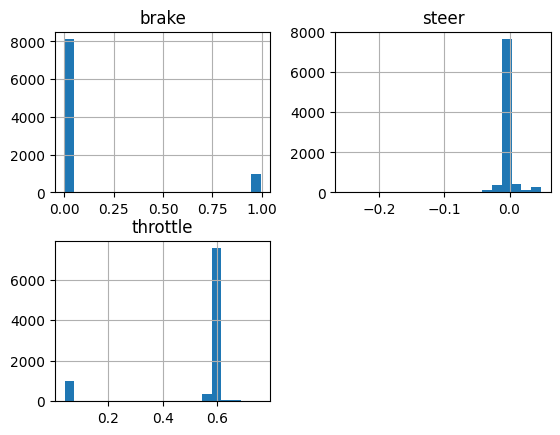

In [ ]:
df_pred.hist(bins=20)

In [ ]:
df_residuals = df_true - df_pred

array([[<AxesSubplot: title={'center': 'brake'}>,
        <AxesSubplot: title={'center': 'steer'}>],
       [<AxesSubplot: title={'center': 'throttle'}>, <AxesSubplot: >]],
      dtype=object)

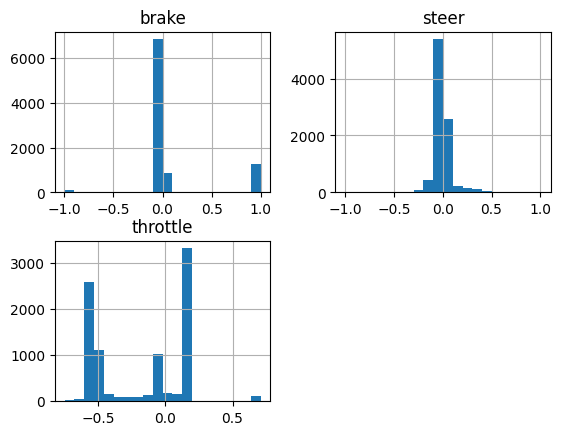

In [ ]:
df_residuals.hist(bins=20)

## Experiment which operators/function can be executed on device

In [ ]:
sum([torch.tensor([1, 2], device=torch.device("mps")), torch.tensor([1, 2], device=torch.device("mps"))])

tensor([2, 4], device='mps:0')

In [ ]:
# Preprocessing could be done on GPU but not on MPS (Apple)
preprocessing["rgb"](torch.rand((3, 160, 960), device=torch.device("mps")))

tensor([[[-1.5880, -1.5818, -1.5906,  ..., -1.5935, -1.5822, -1.5898],
         [-1.5930, -1.5885, -1.5856,  ..., -1.5849, -1.5842, -1.5823],
         [-1.5916, -1.5824, -1.5912,  ..., -1.5888, -1.5918, -1.5912],
         ...,
         [-1.5876, -1.5815, -1.5863,  ..., -1.5863, -1.5891, -1.5891],
         [-1.5907, -1.5873, -1.5811,  ..., -1.5932, -1.5911, -1.5855],
         [-1.5811, -1.5949, -1.5936,  ..., -1.5817, -1.5894, -1.5840]],

        [[-1.3437, -1.3457, -1.3556,  ..., -1.3549, -1.3420, -1.3563],
         [-1.3516, -1.3566, -1.3536,  ..., -1.3507, -1.3517, -1.3536],
         [-1.3434, -1.3525, -1.3566,  ..., -1.3443, -1.3414, -1.3515],
         ...,
         [-1.3487, -1.3424, -1.3464,  ..., -1.3550, -1.3503, -1.3463],
         [-1.3541, -1.3570, -1.3488,  ..., -1.3472, -1.3501, -1.3563],
         [-1.3416, -1.3412, -1.3502,  ..., -1.3461, -1.3422, -1.3530]],

        [[-1.1878, -1.1793, -1.1850,  ..., -1.1920, -1.1868, -1.1808],
         [-1.1811, -1.1790, -1.1906,  ..., -1

In [ ]:
torch.tensor([1, 2], device=torch.device("mps")).device

device(type='mps', index=0)

In [ ]:
test_dict = {"t1": torch.tensor([1, 2, 3])}
# [test_dict[key].to(torch.device("mps")) for key in test_dict]
for key in test_dict:
    test_dict[key] = test_dict[key].to(torch.device("mps"))

In [21]:
torch_values = torch.tensor([0, 1, 2, 3, 4], device=torch.device("mps"))
torch_IDX = torch.tensor([0, 2])

In [22]:
torch_values[torch_IDX]

tensor([0, 2], device='mps:0')

In [21]:
dirs = os.listdir("runs")
dirs_creation_time = [os.path.getctime(os.path.join("runs", dir)) for dir in dirs]


In [26]:
[el[0] for el in sorted(zip(dirs, dirs_creation_time), key=lambda x: x[1])][-1]

'Feb03_18-24-31_MBPvonJulian2.fritz.box'

In [19]:
os.path.getctime('runs/Feb03_15-22-49_MBPvonJulian2.fritz.box')

1675434169.053314